# HW1: Image Processing and Features

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.data
import site
print(site.getsitepackages())
print(cv2.__version__)
%matplotlib inline

['C:\\Anaconda\\envs\\cv', 'C:\\Anaconda\\envs\\cv\\lib\\site-packages']
3.4.2


Load an image (grayscale)

In [19]:
im = skimage.data.camera()

Some helper functions for performing a Fourier Trasnform:

In [20]:
def show_ft(shift,subplt=111,title='FT Spectrum'):
    magnitude_spectrum = 20*np.log(np.abs(shift))
    if subplt != None:
        plt.subplot(subplt)
    plt.title(title)
    plt.imshow(magnitude_spectrum,cmap='Spectral',interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

def ft(im,newsize=None):
    dft = np.fft.fft2(np.float64(im),newsize)
    return np.fft.fftshift(dft)

def ft_and_show(im,subplt=111,newsize=None,title='FT Spectrum'):
    shift = ft(im, newsize)
    show_ft(shift, subplt, title)
    return shift

def ift(shift):
    f_ishift = np.fft.ifftshift(shift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

def ift_and_show(shift,subplt=111,title='Reconstructed Image'):
    img_back = ift(shift)
    if subplt != None:
        plt.subplot(subplt)
    plt.title(title)
    plt.imshow(img_back,cmap='gray',interpolation='nearest')
    return img_back

Given an image we apply any convolution kernel arbitrarily by transforming both image and kernel to the frequency domain.

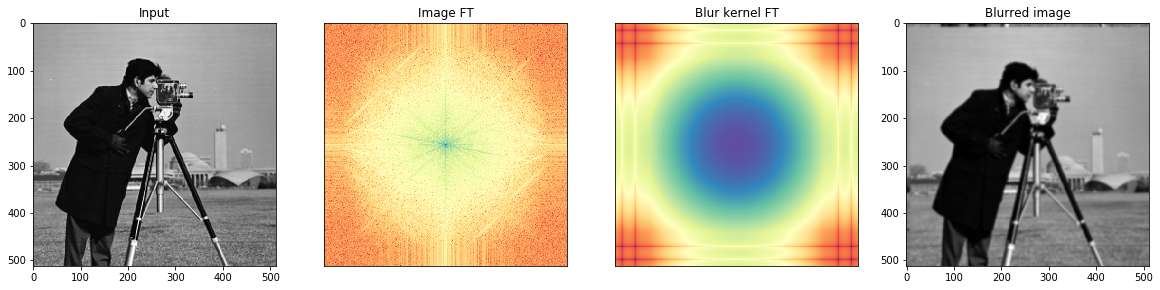

In [21]:
# Create a 17x17 Gaussian kernel
gk = cv2.getGaussianKernel(17,2)
gk = gk * gk.T

# Show the blur operation done by FT
plt.figure(figsize=(20,10))
plt.subplot(141),plt.imshow(im, cmap='gray'),plt.title('Input')
imf = ft_and_show(im, 142, (im.shape[1],im.shape[1]), 'Image FT') # image in F domain
ckf = ft_and_show(gk, 143, (im.shape[1],im.shape[1]), 'Blur kernel FT') # kernel in F domain
imconvf = imf * ckf # multiplication in Freq domain = convolution in spatial domain
imconv = ift_and_show(imconvf, 144, 'Blurred image')

---
---

## Here comes your part
<img src="https://echealthandfitness.com/wp-content/uploads/2018/05/you-can-do-it-i-believe-in-you-meme.jpg" width="30%"/>


## Convolution Theorem

Deconvolve the image `imconv` given the (Gaussian) kernel that created it `gk`, and show the result. Use `ft` and `ift` functions from above.

This is what we'd expect:

(<matplotlib.axes._subplots.AxesSubplot at 0x1b25a282080>,
 Text(0.5, 1.0, 'Deconvolved'))

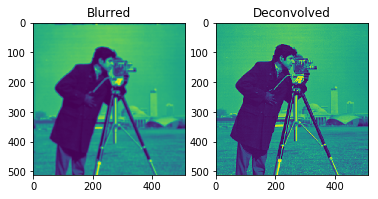

In [22]:
# make sure sizes match so we can multiple easily
imf = ft(imconv,(im.shape[1],im.shape[1])) # TODO: your code, get the FT of imconv

gkf = ft(gk,(im.shape[1],im.shape[1])) # TODO: your code, get the FT of gk
deconvft = imf /gkf # TODO: your code, in the FT "de-apply" the kernel

# now reconstruct the blurred image from its FT
unblurred = ift(deconvft) # TODO: your code, use deconvft

plt.subplot(121),plt.imshow(imconv),plt.title('Blurred')
plt.subplot(122),plt.imshow(unblurred),plt.title('Deconvolved')

## Corner Detection
Implement the Harris corner detector.

Use the functions `cv2.Sobel` and `cv2.Gaussian Blur` to implement the Harris corner criteria:
$$
Harris(\hat{M}) = \det(\hat{M})-\alpha\mathrm{trace}(\hat{M}) \approx G(I_x^2)G(I_y^2)-G(I_xI_y)^2-\alpha[G(I_x)^2+G(I_y)^2]^2
$$
Where $G$ is the Gaussian blur operator, and $I_x,I_y$ are image derivatives (Sobel) in $x$ and $y$.

In [23]:
def harris(im, k = int(3), alpha = 0.05):
    # k is the kernel size for the Gaussian blue, alpha is the free parameter
    # TODO: your code here
    #hint: 
    dx = cv2.Sobel(im, -1, 1, 0)
    dy = cv2.Sobel(im,-1,0,1)
    gx2 = cv2.GaussianBlur(dx**2,(k,k),-1)
    gy2 = cv2.GaussianBlur(dy**2,(k,k),-1)
    
    gxy2 = cv2.GaussianBlur((dx*dy),(k,k),-1)**2
                  
    gxy = alpha*(cv2.GaussianBlur((dx),(k,k),-1)**2  +  cv2.GaussianBlur((dy),(k,k),-1)**2 )**2 

    return gx2*gy2 - gxy2 - gxy

Here is an example of what this would look like:

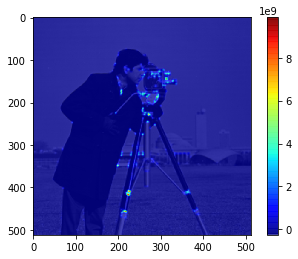

In [24]:
plt.imshow(im, cmap='gray')
har = harris(np.float64(im), 11, 0.05)
plt.imshow(har, cmap='jet', alpha=0.75),plt.colorbar();

## Feature Matching

Load the exercise images:

In [25]:
import requests
im1 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1y8eKxsxxQDDxnwZex_qNi_1QtEmr7xai").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im2 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1ZRNAyo9SUeL0BcTJKFzKuEku2-YTkvA9").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im3 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1DPGLB1NtZiPEhSVHnVq_1yc5d5XSCEjf").content, np.uint8), cv2.IMREAD_GRAYSCALE)

Make sure the download worked

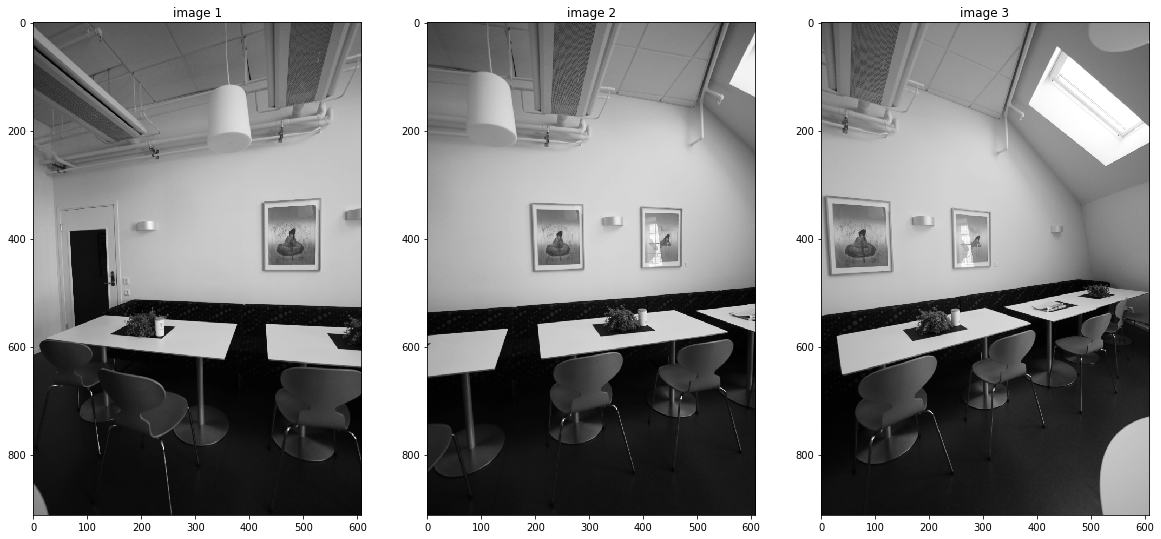

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(im1, cmap='gray'),plt.title('image 1')
plt.subplot(132),plt.imshow(im2, cmap='gray'),plt.title('image 2')
plt.subplot(133),plt.imshow(im3, cmap='gray'),plt.title('image 3');

Use image 1 and image 2

Extract SIFT keypoints and descriptors from both images (`cv2.xfeatures2d.SIFT_create()` and `.detectAndCompute()`).

Match the descriptors (2-nn) and apply the ratio test (`cv2.BFMatcher_create` and `.knnMatch()`)

Show the matching before and after the ratio test (`cv2.drawMatchesKnn`)

Consult: https://docs.opencv.org/4.0.1/dc/dc3/tutorial_py_matcher.html

In [27]:
# TODO: your code here
# hint: 
sift = cv2.xfeatures2d.SIFT_create()
kpts1,desc1 = sift.detectAndCompute(im1,None)
kpts2,desc2 = sift.detectAndCompute(im2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1,desc2, k=2)

# Apply ratio test with 0.75 difference factor
good = []

for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# for future use in the next question, align the "good" points in two arrays
pts1,pts2 = np.array([[0,0]]*len(good)),np.array([[0,0]]*len(good))
for i,match in enumerate(good):
    pts1[i] = kpts1[match[0].queryIdx].pt
    pts2[i] = kpts2[match[0].trainIdx].pt

This is how it should look like:

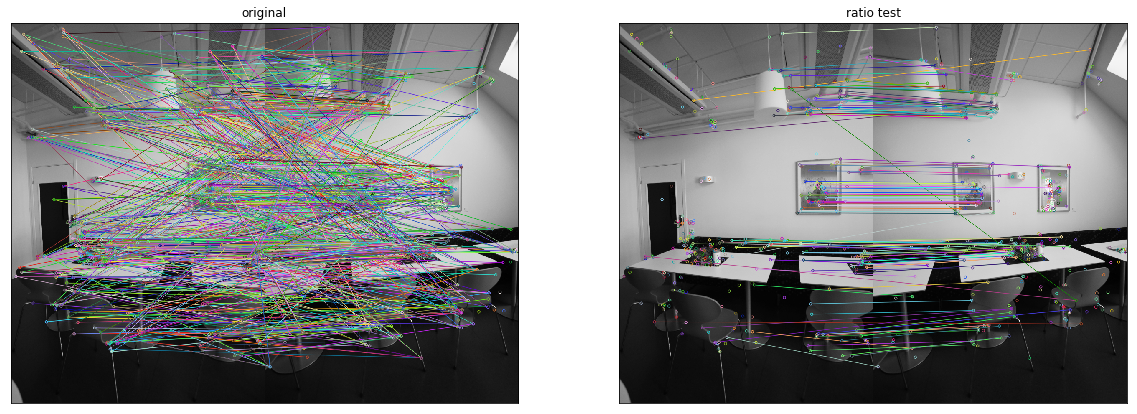

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,matches,im1.copy())), plt.title('original')
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title('ratio test')
plt.setp(plt.gcf().get_axes(),xticks=[],yticks=[]);

## Geometric Model Fitting

Given the above matching (make sure you keep the `good` variable!)

* Find a homography using unconstrained Linear Least Squares by solving a $AX=0$ equation (use `np.linalg.svd`), and show the resulting homography warping (`cv2.warpPerspective`).

Let $p_i^{(1)}=(x_i^{(1)},y_i^{(1)})$ and $p_i^{(2)}=(x_i^{(2)},y_i^{(2)})$ be matching points in images 1 and 2 respectively, recall:
$$
\begin{pmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{pmatrix}
\begin{pmatrix}
x_i^{(1)} \\ y_i^{(1)} \\ 1
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\lambda
\begin{pmatrix}
x_i^{(2)} \\ y_i^{(2)} \\ 1
\end{pmatrix}
=
\begin{pmatrix}
\lambda x_i^{(2)} \\ \lambda y_i^{(2)} \\ \lambda
\end{pmatrix}
\,\,\,,\,\,\,
\hat{x_i^{(2)}} = x_i^{(2)} / \lambda\,\,\,, \,\,\,
\hat{y_i^{(2)}} = y_i^{(2)} / \lambda
$$
$$
\hat{x_i^{(2)}} = \frac{h_1x_i^{(1)}+h_2y_i^{(1)}+h_3}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
\,\,\,, \,\,\,
\hat{y_i^{(2)}} = \frac{h_4x_i^{(1)}+h_5y_i^{(1)}+h_6}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
$$
$$
h_7\hat{x_i^{(2)}}x_i^{(1)}+h_8\hat{x_i^{(2)}}y_i^{(1)}+h_9\hat{x_i^{(2)}} - h_1x_i^{(1)} - h_2y_i^{(1)} - h_3 = 0\\
h_7\hat{y_i^{(2)}}x_i^{(1)}+h_8\hat{y_i^{(2)}}y_i^{(1)}+h_9\hat{y_i^{(2)}} - h_4x_i^{(1)} - h_5y_i^{(1)} - h_6 = 0
$$
And thus:
$$
\begin{pmatrix}
& \cdots & \\
-x_i^{(1)} & -y_i^{(1)} & -1 & 0 & 0 & 0 & \hat{x_i^{(2)}}x_i^{(1)} & \hat{x_i^{(2)}}y_i^{(1)} & \hat{x_i^{(2)}} \\
0 & 0 & 0 & -x_i^{(1)} & -y_i^{(1)} & -1 & \hat{y_i^{(2)}}x_i^{(1)} & \hat{y_i^{(2)}}y_i^{(1)} & \hat{y_i^{(2)}}  \\
& \cdots & 
\end{pmatrix}
\begin{pmatrix}
h_1 \\ h_2 \\ h_3 \\
h_4 \\ h_5 \\ h_6 \\
h_7 \\ h_8 \\ h_9
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
\cdots \\ 0 \\ 0 \\ \cdots 
\end{pmatrix}
$$

* Find a homography using RANSAC (`M, mask = cv2.findHomography`), show only the inliers pair-matches that survived RANSAC as well as the final warping

---

In [33]:
# a utility for warping and blending images
def warpAndblendImages(image1,image2,H):
    h_,w_ = image1.shape
    im2warp = cv2.warpPerspective(im2, H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    im2mask = cv2.warpPerspective(np.ones_like(im2), H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    return image1 * (1.0 - im2mask) + im2warp * im2mask

In [34]:
# make a copy of image 1 with room on the right for image 2
im1wide = np.hstack([im1, np.zeros_like(im1)])

Implement and Run the LLSQ method for finding homography

In [35]:
print(pts1.shape)
# homogeneous linear least squares solution for finding a homography
def findHomographyLLSQ(ptsLeft, ptsRight):
    A = np.repeat(np.array([[0]*9] * len(ptsLeft), np.float32), 2, axis=0)
    for i in range(len(ptsLeft)):
        x1 = ptsLeft[i][0]
        y1 = ptsLeft[i][1]
        x2 = ptsRight[i][0]
        y2 = ptsRight[i][1]
        
        A[2*i][0] = -x1
        A[2*i][1] = -y1
        A[2*i][2] = - 1
        A[2*i][6] = x2*x1
        A[2*i][7] = x2*y1
        A[2*i][8] = x2
        
        A[2*i+1][3] = -x1
        A[2*i+1][4] = -y1
        A[2*i+1][5] = - 1
        A[2*i+1][6] = y2*x1
        A[2*i+1][7] = y2*y1
        A[2*i+1][8] = y2       
    
    # take the SVD of A (`np.linalg.svd`) and pick the last row of Vt (last column of V)
    # TODO: your code here...
    _,_,vt = np.linalg.svd(A)
    H = vt[-1].reshape(3,3) # reshape back to 3,3
    return H/H[2,2]

(154, 2)


In [36]:
H = findHomographyLLSQ(pts1,pts2)
print(H)
lstsqWarp = warpAndblendImages(im1wide, im2, H)

[[-8.6072153e-01 -1.6774708e-01  3.9819257e+02]
 [-1.2834517e+00 -4.2295668e-01  6.5212122e+02]
 [-2.2974135e-03 -4.4118974e-04  1.0000000e+00]]


Run the RANSAC method for finding homography

In [37]:
H,mask = cv2.findHomography(pts1,pts2,method=cv2.RANSAC)
print(H)
findHomogWarp = warpAndblendImages(im1wide, im2, H)

[[ 2.28989850e+00  4.61385313e-02 -6.29556388e+02]
 [ 8.61549457e-01  1.86566913e+00 -3.62277608e+02]
 [ 2.05165074e-03 -9.59323851e-06  1.00000000e+00]]


Display the results

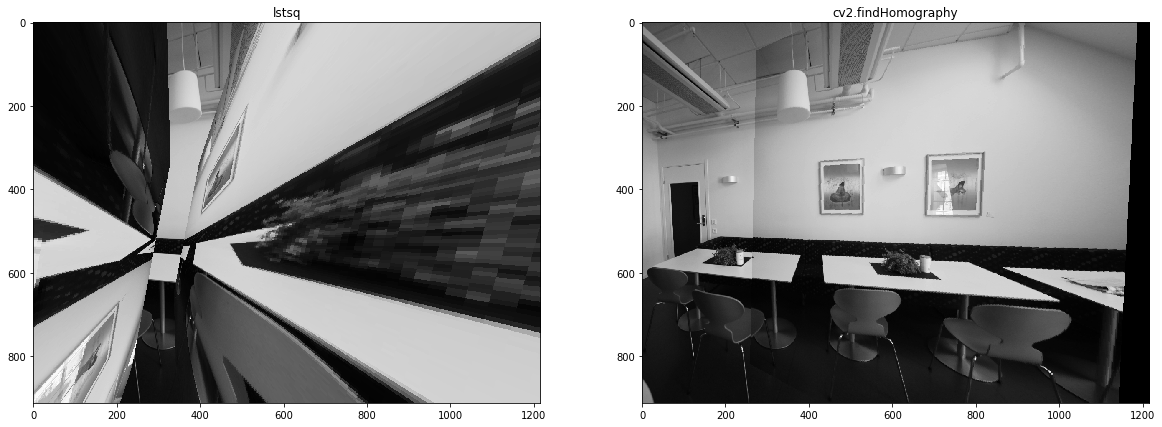

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(lstsqWarp, cmap='gray'), plt.title('lstsq')
plt.subplot(122),plt.imshow(findHomogWarp, cmap='gray'), plt.title('cv2.findHomography');

What was the method that produced the best (valid) image alignment result?

In [39]:
cv2.findHomography

<function findHomography>

It seems that even a small proportion of outliers in the matching can cause devastating results.

Now that we have the `mask` of inlier points that were included in the final homography calculation, try running `findHomographyLLSQ` again with the mask:

[[ 2.3022161e+00  4.5550659e-02 -6.3332263e+02]
 [ 8.6865985e-01  1.8722111e+00 -3.6520483e+02]
 [ 2.0705152e-03 -1.2980249e-05  1.0000000e+00]]


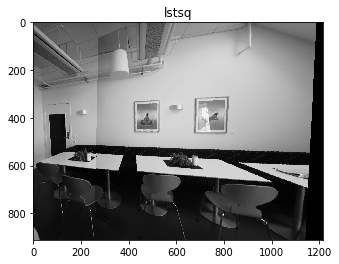

In [40]:
H = findHomographyLLSQ(pts1[mask[:,0]==1],pts2[mask[:,0]==1])
print(H)
lstsqWarp = warpAndblendImages(im1wide, im2, H)
plt.imshow(lstsqWarp, cmap='gray'), plt.title('lstsq');

Is it looking better now? :)

## Panoramic Stitching

Use the 3 images for the panorama

Apply cylindrical warping to each

Find keypoints and features in the warped images

Find a strictly translational model to align the 3 images

Show the final stitching

In [41]:
# utility function to get the cylindrical warp (optimized method without for loops)
def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    # warp the image according to cylindrical coords
    return cv2.remap(img, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)

In [42]:
# get the cylindrical warping for the three inputs
h, w = im1.shape[:2]
K = np.array([[440,0,w/2],[0,440,h/2],[0,0,1]]) # mock intrinsics
im_cyl = [cylindricalWarp(im_, K) for im_ in [im1,im2,im3]]
im_cyl_mask1 = cylindricalWarp(np.ones_like(im1), K) # mask of the warp, is needed for stitching
im_cyl_mask2 = cylindricalWarp(np.ones_like(im2), K)
im_cyl_mask3 = cylindricalWarp(np.ones_like(im3), K)

In [43]:
# find tx,ty the translation from image 1 to image 2
# TODO: complete this function
def findTranslation(im1_, im2_):
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    kpts1,desc1 = sift.detectAndCompute(im1_,None)
    kpts2,desc2 = sift.detectAndCompute(im2_,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1,desc2, k=2)

    # Apply ratio test with 0.75 difference factor


    # find the keypoints and descriptors with SIFT
    # TODO: your code

    # BFMatcher with default params
    # TODO: your code
    
    # Apply ratio test
    good = []
    
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    plt.imshow(cv2.drawMatchesKnn(im1_,kpts1,im2_,kpts2,good,im1_.copy(),flags=2))
    
    # get aligned point lists
    pts1,pts2 = np.array([[0,0]]*len(good)),np.array([[0,0]]*len(good))
    for i,match in enumerate(good):
        pts1[i] = kpts1[match[0].queryIdx].pt
        pts2[i] = kpts2[match[0].trainIdx].pt     


    # return the translation
    # think about the outliers!
    translation = np.subtract(pts1,pts2)
    return np.median(translation[:,0]), np.median(translation[:,1])

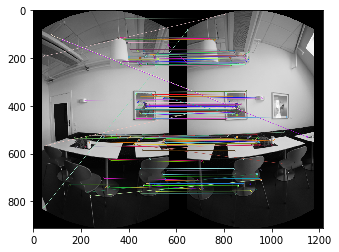

In [44]:
tx01,ty01 = findTranslation(im_cyl[0],im_cyl[1])

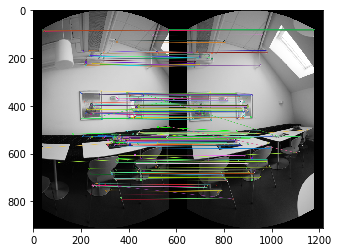

In [45]:
tx12,ty12 = findTranslation(im_cyl[1],im_cyl[2])

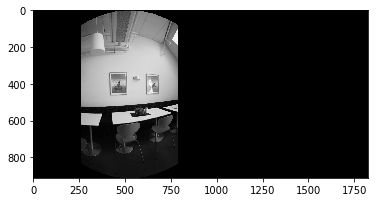

In [48]:
# make some room for the other images
# im1_cyl_wide = np.hstack([im_cyl[0],np.zeros_like(im_cyl[0]),np.zeros_like(im_cyl[0])])
im1_cyl_wide = np.hstack([im_cyl[0],np.zeros_like(im_cyl[0]),np.zeros_like(im_cyl[0])])

M1 = np.float64([[1,0,tx01],[0,1,ty01]])
M2 = np.float64([[1,0,tx12+tx01],[0,1,ty12]])

shp = im1_cyl_wide.shape
im2_cyl_wide = np.hstack([im_cyl[1],np.zeros_like(im_cyl[0]),np.zeros_like(im_cyl[0])])
im2Translated = cv2.warpAffine(im2_cyl_wide,M1,(shp[1],shp[0]))

im3_cyl_wide = np.hstack([im_cyl[2],np.zeros_like(im_cyl[0]),np.zeros_like(im_cyl[0])])
im3Translated = cv2.warpAffine(im3_cyl_wide,M2,(shp[1],shp[0]))

plt.imshow(im2Translated,cmap='gray');


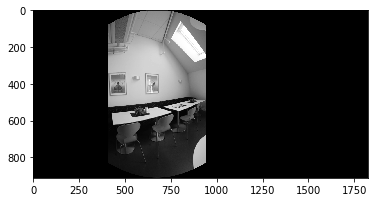

In [47]:
plt.imshow(im3Translated,cmap='gray');


In [49]:
# TODO: your code
# stitch the images into `im1_cyl_wide`, use the mask
def blend(image1,image2):
    shp = image1.shape
    image = np.zeros_like(image1)
    for i in range(shp[0]):
        for j in range(shp[1]):
            image[i][j] = max(image1[i][j],image2[i][j])
                
    return image             
im1_cyl_wide = blend(blend(im1_cyl_wide,im2Translated),im3Translated)

Finally, show the result

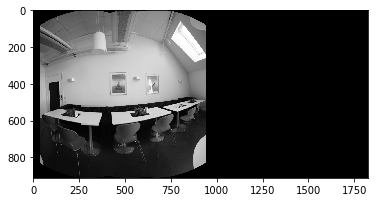

In [50]:
plt.imshow(im1_cyl_wide,cmap='gray');

Doesn't that look nice? you did it all on your own

In [ ]:
print("Yes. Beautiful")